Everything here is a minor tweak from the lecture on decision trees. Primary motivation is to forecast energy generated using other lagged variables.

# Ensemble Learning
- problem: trees tend to overfit data (i.e., high variance predictors albeit with low bias)
 - Can correct for high variance by using shallow trees (depth 3 to 5).    - But this lacks accuracy, so we should use many different trees and aggregate the results.
   - Bagging (bootstrap aggregation) on the data
     - sample from traning data with replacement
     - combine the data by taking the average (regression) or by voting (class)
     - these can be deep trees
     - potential problem: every tree has the same top node.
     - solution: restrict each tree to a random subset of the predictors. This is called a **random forest**.
   - Boosting: make a tree then fit a tree to the residuals and repeat
       - reduces bias
- how many trees? how deep? how many predictors? All soft questions called **hyperparameters**.
- loss function
- pruning: taking out nodes and refitting?

In [32]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz # might need to install -- need *both* python and system
# so use Anaconda (or pip) to install graphviz, and also https://graphviz.org/download/
# this was a non-trivial install on Mac (depends on Xcode command-line tools)
# `pip install graphviz` and `brew install graphviz`
import datetime as dt

%matplotlib inline

# 8.3.1 Fitting Classification Trees

The `sklearn` library has a lot of useful tools for constructing classification and regression trees:

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error

Train/test model on data up to 2017. Will test model on 2018/2019 later.

# TO DO: Import weather data
# TO DO: Break up data into 5-year chunks

**what's a reasonable average**

In [135]:
df = pd.read_csv("../Data/1999_2021/aggragate_daily_data_2000to2020.csv", index_col = "date").drop(labels = "Unnamed: 0", axis = 1)
df_2017 = df.loc['2000-01-01':'2017-12-31'].copy()
avg = df['energy_generated'].mean()                    #avg is average of energy_generated from 2000 to present
df_2017['high'] = df_2017.energy_generated.map(lambda x: 1 if x > avg else 0) 

Adding 7 day, 14 day, 30 day, 90 day lags to all variables except energy_generated.

In [203]:
'''
df_2017_7 = df_2017.copy()
df_2017_14 = df_2017.copy()
df_2017_30 = df_2017.copy()
df_2017_90 = df_2017.copy()
'''

SyntaxError: cannot assign to operator (<ipython-input-203-b11f787fcf21>, line 7)

In [166]:

for i in [7,14,30,90]:    #this is so UGLY I wish I knew how to code :(
    df_2017_lagged[['energy_charge_' + str(i)]] = df_2017_lagged.energy_charge.shift(-i)
    df_2017_lagged[['effluent_flow_' + str(i)]] = df_2017_lagged.effluent_flow.shift(-i)
    df_2017_lagged[['influent_flow_' + str(i)]] = df_2017_lagged.influent_flow.shift(-i)
    df_2017_lagged[['volume_used_' + str(i)]] = df_2017_lagged.volume_used.shift(-i)
    df_2017_lagged[['poured_flow_' + str(i)]] = df_2017_lagged.poured_flow.shift(-i)
    df_2017_lagged[['water_level_' + str(i)]] = df_2017_lagged.water_level.shift(-i)
    df_2017_lagged[['energy_stored_' + str(i)]] = df_2017_lagged.energy_stored.shift(-i)
    df_2017_lagged[['maximum_demand_' + str(i)]] = df_2017_lagged.maximum_demand.shift(-i)
    
df_2017_lagged = df_2017_lagged.dropna()


We now use the `DecisionTreeClassifier()` function to fit a classification tree in order to predict
`High`. Unfortunately, manual pruning is not implemented in `sklearn`: http://scikit-learn.org/stable/modules/tree.html

However, we can limit the depth of a tree using the `max_depth` parameter.

**what the heck is a good train size**

Comment: removed current effluent_flow because it's too correlated with energy_generated. If you want to drop a variable from the tree do it here

In [229]:
X = df_2017_lagged.drop(['energy_generated', 'high','effluent_flow'], axis = 1)
y = df_2017_lagged.high
lst=[]

for k in range(1,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = k*.1, random_state = 0)
    for x in range(1,11):
        classification_tree_daily = DecisionTreeClassifier(max_depth = x)
        classification_tree_daily.fit(X_train, y_train)
        lst.append([x,k,classification_tree_daily.score(X_train, y_train)])

**comment**: Adding all lags on all variables at once makes the training score go down (was previously 0.99 with 30 lag on everything.)

From the resulting lst I arbitrarily chose train_size = 0.6, max_depth = 6

One of the most attractive properties of trees is that they can be
graphically displayed. Unfortunately, this is a bit of a roundabout process in `sklearn`. We use the `export_graphviz()` function to export the tree structure to a temporary `.dot` file,
and the `graphviz.Source()` function to display the image:

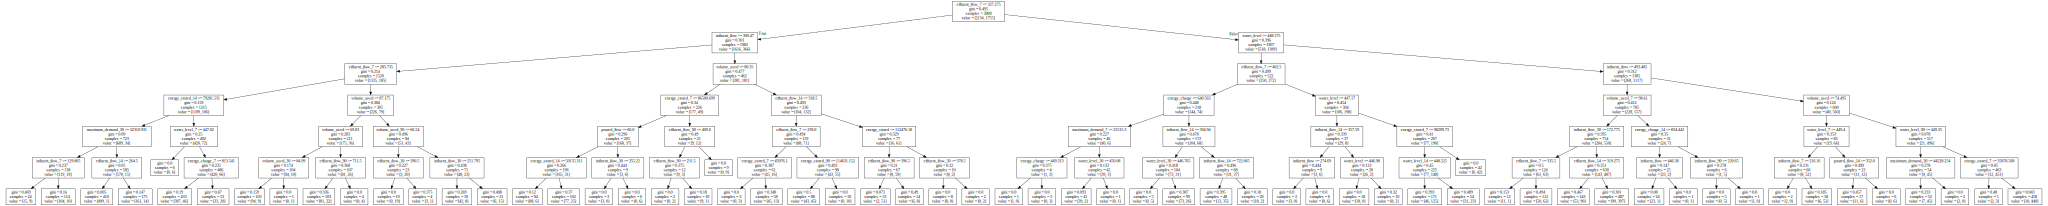

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.6, random_state = 0)
classification_tree_daily = DecisionTreeClassifier(max_depth = 6)
classification_tree_daily.fit(X_train, y_train)

export_graphviz(classification_tree_daily, 
                out_file = "tree.dot", 
                feature_names = X_train.columns)

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Max depth of 6, train_size of 0.8: effluent_flow, effluent_flow_7, influent_flow, effluent_flow_14 were the most important indicators in that order when all lags are included.


Finally, let's evaluate the tree's performance on
the test data. The `predict()` function can be used for this purpose. We can then build a confusion matrix.

In [231]:
pred = classification_tree_daily.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, 
                  index = ['No', 'Yes'], 
                  columns = ['No', 'Yes'])
print(cm)

       No  Yes
No   1131  239
Yes   307  917


terribad

# 8.3.2 Fitting Regression Trees

Now let's try fitting a **regression tree**. 

In [248]:
X = df_2017_lagged.drop(['energy_generated','high','effluent_flow','effluent_flow_7','influent_flow'], axis = 1)
y = df_2017_lagged.energy_generated
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

# Pruning not supported. Choosing max depth 2)
regr_tree_daily = DecisionTreeRegressor(max_depth = 3)
regr_tree_daily.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

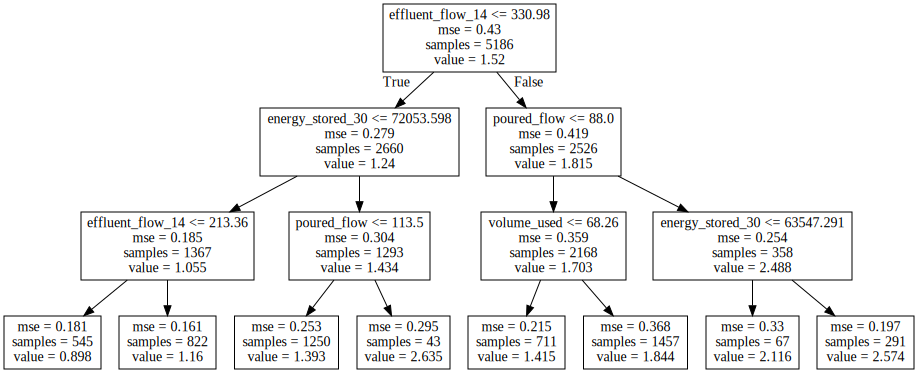

In [249]:
export_graphviz(regr_tree_daily, 
                out_file = "regr_tree.dot", 
                feature_names = X_train.columns)

with open("regr_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

max depth of 2 or 3: effluent_flow, effluent_flow_7,influent_flow,effluent_flow_14

0.2719383839839958

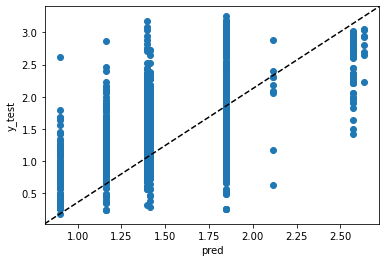

In [250]:
pred = regr_tree_daily.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'medv')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_squared_error(y_test, pred)

The test set MSE associated with the regression tree is
35.4. The square root of the MSE is therefore around 5.95, indicating
that this model leads to test predictions that are within around \$5,950 of
the true median home value for the suburb.
    
# 8.3.3 Bagging and Random Forests

Let's see if we can improve on this result using **bagging** and **random forests**. The exact results obtained in this section may
depend on the version of `python` and the version of the `RandomForestRegressor` package
installed on your computer, so don't stress out if you don't match up exactly with the book. Recall that **bagging** is simply a special case of
a **random forest** with $m = p$. Therefore, the `RandomForestRegressor()` function can
be used to perform both random forests and bagging. Let's start with bagging:

In [256]:
df_2017_lagged.shape

(6483, 42)

In [264]:
# Bagging: using all features
bagged_daily = RandomForestRegressor(max_features = 37, random_state = 1)
bagged_daily.fit(X_train, y_train)

RandomForestRegressor(max_features=37, random_state=1)

0.11653332168442608

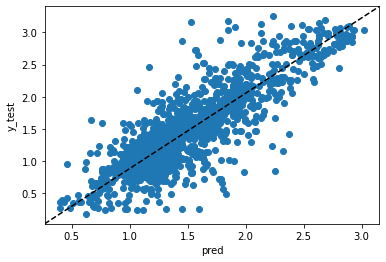

In [265]:
pred = bagged_daily.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'medv')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_squared_error(y_test, pred)

The test set MSE associated with the bagged regression tree is significantly lower than our single tree!

In [267]:
# Random forests: using 6 features
random_forest_daily = RandomForestRegressor(max_features = 8, random_state = 1)

random_forest_daily.fit(X_train, y_train)

pred = random_forest_daily.predict(X_test)
mean_squared_error(y_test, pred)

0.10785263200791692

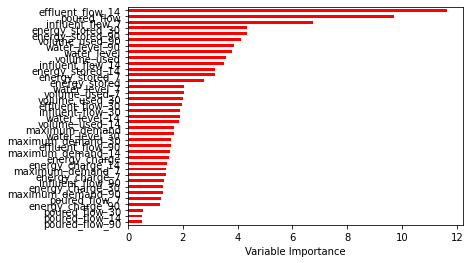

In [268]:
Importance = pd.DataFrame({'Importance':random_forest_daily.feature_importances_*100}, 
                          index = X.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

# 8.3.4 Boosting

Now we'll use the `GradientBoostingRegressor` package to fit **boosted
regression trees** to the `Boston` data set. The
argument `n_estimators = 500` indicates that we want 500 trees, and the option
`interaction.depth = 4` limits the depth of each tree:

In [269]:
boosted_daily = GradientBoostingRegressor(n_estimators = 500, 
                                           learning_rate = 0.01, 
                                           max_depth = 4, 
                                           random_state = 1)

boosted_daily.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=500,
                          random_state=1)

Let's check out the feature importances again:

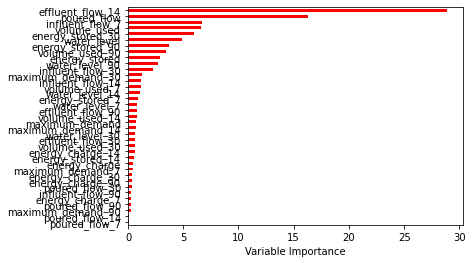

In [270]:
feature_importance = boosted_daily.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X.columns).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

We see that `lstat` and `rm` are again the most important variables by far. Now let's use the boosted model to predict `medv` on the test set:

In [271]:
mean_squared_error(y_test, boosted_daily.predict(X_test))

0.18092396431772545

If we want to, we can perform boosting
with a different value of the shrinkage parameter $\lambda$. Here we take $\lambda = 0.2$:

In [272]:
boosted_daily2 = GradientBoostingRegressor(n_estimators = 500, 
                                            learning_rate = 0.2, 
                                            max_depth = 4, 
                                            random_state = 1)
boosted_daily2.fit(X_train, y_train)

mean_squared_error(y_test, boosted_daily2.predict(X_test))

0.10172548052281982

In this case, using $\lambda = 0.2$ leads to a slightly lower test MSE than $\lambda = 0.01$.

To get credit for this lab, post your responses to the following questions:
 - What's one real-world scenario where you might try using Bagging?
 - What's one real-world scenario where you might try using Random Forests?
 - What's one real-world scenario where you might try using Boosting?
 
to Moodle: https://moodle.smith.edu/mod/quiz/view.php?id=264671